In [27]:
import torch

DEVICE = "cpu" if not torch.cuda.is_available() else "cuda"

In [28]:
# Create function to load dataset from csv file. Data from month column will be output as X_month,
# data from day column will be output as X_day, data from hour column will be output as X_hour,
# data from tx_count will be output as y, and all other data will be output as X_numeric.
# All data will be converted to tensors.

import os
import pandas as pd

def load_dataset(
    csv_file: os.PathLike,
    window_size: int,
    y_scaling_min: float = None,
    y_scaling_factor: float = None
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, float, float]:
    # Sanity check on params
    both_not_none = y_scaling_min is not None and y_scaling_factor is not None
    both_none = y_scaling_min is None and y_scaling_factor is None
    assert both_not_none or both_none

    # Read the raw data from the file
    df = pd.read_csv(csv_file)

    # Conver the data to tensors
    raw_X_month = torch.tensor(df['month'].values)
    raw_X_day = torch.tensor(df['day'].values)
    raw_X_hour = torch.tensor(df['hour'].values)
    raw_X_numeric = torch.tensor(df.drop(['month', 'day', 'hour', 'y'], axis=1).values).float()
    raw_y = torch.tensor(df['y'].values).float()

    # Make sure we are using a window size that makes sense with our data
    window_size = min(window_size, len(raw_X_month) // 2)

    # Get sliding windows of the data
    X_month = raw_X_month.unfold(0, 2 * window_size, 1)
    X_day = raw_X_day.unfold(0, 2 * window_size, 1)
    X_hour = raw_X_hour.unfold(0, 2 * window_size, 1)
    X_numeric = raw_X_numeric.unfold(0, 2 * window_size, 1).transpose(-1, -2)
    y = raw_y.unfold(0, 2 * window_size, 1)
    y = y[:, -window_size:]

    # Scale the ys
    if both_none:
        y_scaling_min = y.min()
        y_scaling_factor = y.max() - y.min()
    y = (y - y_scaling_min) / y_scaling_factor

    return X_month, X_day, X_hour, X_numeric, y, y_scaling_min, y_scaling_factor

In [ ]:
# Create a PyTorch model that takes in 4 inputs (X_month, X_day, X_hour, X_numeric)
# and outputs a series of predictions (y). It will feed X_month, X_day, and X_hour into embedding layers,
# which will then be concatenated with X_numeric and fed into an LSTM layer.

import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding_month = nn.Embedding(12, 2)
        self.embedding_day = nn.Embedding(31, 25)
        self.embedding_hour = nn.Embedding(24, 50)
        self.normalizer = nn.BatchNorm1d(5)
        self.lstm = nn.LSTM(82, 100, 5, bidirectional=True, batch_first=True, dropout=0.1)
        self.linear = nn.Sequential(
            nn.Linear(200, 40),
            nn.Linear(40, 10),
            nn.Linear(10, 1)
        )

    def forward(self, X_month, X_day, X_hour, X_numeric):
        X_month = self.embedding_month(X_month)
        X_day = self.embedding_day(X_day)
        X_hour = self.embedding_hour(X_hour)
        X_numeric = self.normalizer(X_numeric.transpose(-1, -2)).transpose(-1, -2)
        X = torch.cat((X_month, X_day, X_hour, X_numeric), dim=-1)
        X, _ = self.lstm(X)
        X = self.linear(X)
        return X.squeeze()[:, -24:]

In [30]:
# Create a function to train an instance of Model on a given dataset.

import torch.optim as optim
from tqdm.notebook import tqdm

def train_model(
    model: Model,
    X_train: tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],
    y_train: torch.Tensor,
    X_test: tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],
    y_test: torch.Tensor,
    epochs: int
) -> tuple[list[float], list[float]]:
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    pbar = tqdm(range(epochs))
    trn_losses = []
    val_losses = []
    for _ in pbar:
        try:
            # Do a training pass
            model.train()
            optimizer.zero_grad()
            y_pred = model(*X_train)

            # Evaluate the loss and do backpropagation
            loss = nn.L1Loss()(y_pred, y_train)
            loss.backward()
            optimizer.step()

            # Validate
            model.eval()
            with torch.no_grad():
                y_pred = model(*X_test)
                val_loss = nn.L1Loss()(y_pred, y_test)
            pbar.set_description(f'Val. MAE: {val_loss.item():.4f}, Trn. MAE: {loss.item():.4f}')

            trn_losses.append(loss.item())
            val_losses.append(val_loss.item())

        except KeyboardInterrupt:
            break

    return trn_losses, val_losses

In [31]:
with torch.device(DEVICE):
    X_month, X_day, X_hour, X_numeric, y_train, scale_min, scale_factor = load_dataset(
        'data/train.csv',
        24
    )
    X_month_test, X_day_test, X_hour_test, X_numeric_test, y_test, _, _ = load_dataset(
        'data/test.csv',
        24,
        scale_min,
        scale_factor
    )

    model = Model()
    trn_losses, val_losses = train_model(
        model,
        (X_month, X_day, X_hour, X_numeric),
        y_train,
        (X_month_test, X_day_test, X_hour_test, X_numeric_test),
        y_test,
        1000
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

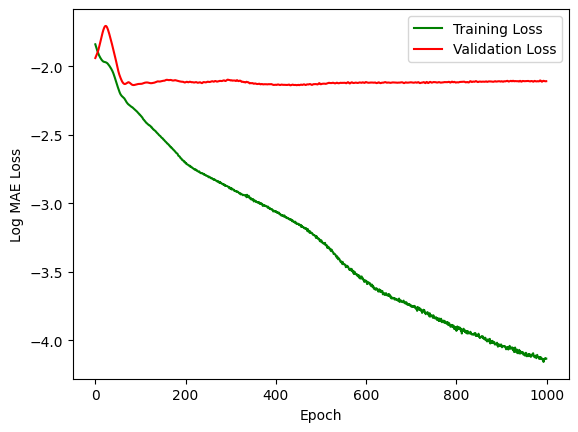

In [32]:
import math
import matplotlib.pyplot as plt

# Plot losses
plt.xlabel("Epoch")
plt.ylabel("Log MAE Loss")
plt.plot([math.log(l) for l in trn_losses], color='green', label="Training Loss")
plt.plot([math.log(l) for l in val_losses], color='red', label="Validation Loss")
plt.legend()
plt.show()

In [33]:
with torch.device(DEVICE):
    with torch.no_grad():
        model.eval()
        y_preds = model.forward(X_month_test, X_day_test, X_hour_test, X_numeric_test)

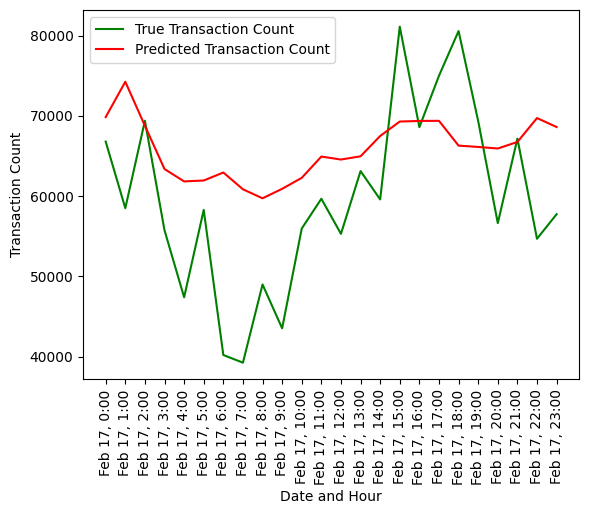

In [ ]:
# Use matplotlib to plot y_test in green and y_preds in red
x_axis = [
    f"Feb {d}, {h}:00"
    for d, h in zip(X_day_test[0, -24:], X_hour_test[0, -24:])
]

plt.xlabel("Date and Hour")
plt.ylabel("Transaction Count")
plt.xticks(range(len(x_axis)), x_axis, rotation=90)
plt.plot(y_test[0].cpu() * scale_factor + scale_min, color='green', label="True Transaction Count")
plt.plot(y_preds[0].cpu() * scale_factor + scale_min, color='red', label="Predicted Transaction Count")
plt.legend()
plt.show()